In [81]:
# import required libraries
from typing import List, Sequence
from langchain_ollama import OllamaLLM
from langgraph.graph import END, MessageGraph
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [82]:
# initialise the LLM
# to set up OLLAMA refer to https://python.langchain.com/docs/integrations/chat/ollama/
llm = OllamaLLM(
    model="llama3",
    temperature=0,
)

In [83]:
def generation_node(state: Sequence[BaseMessage]):
    res = generate.invoke({"messages": state})
    return res

def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect.invoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res)

In [84]:
# generation prompt for minutes of meetings

generation_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system", """You are excellent at creating minutes of meetings. You are provided with a meeting transcript.
            Ensure the summary includes all essential information without adding any new details not present in the transcript. 
            Use the following template for formatting:

            Title: Briefly title the meeting. Should be informative.
            Agenda: Outline the main agenda of the meeting.
            Points Discussed: List key points in bullet form, including any updates discussed. Names should be included if mentioning a task discussed or done by someone.
            Future Items: Mention any future actions or items discussed, if applicable.
            			
            If the user provides any feedback, respond with a revised minutes of meeting. 
            
            Important:
            **DO NOT behave like a chatbot.**
            Always respond with minutes of meeting only.""",
		),
		MessagesPlaceholder(variable_name="messages"),
	]
) 

generate = generation_prompt|llm

In [85]:
# reflection/validation of the mom

reflection_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
            """Review the provided meeting summary against the original transcript and provide **constructive feedback in bullet points on necessary improvements**, ensuring that:
               * The summary adheres to the required **format, coherence, and absence of hallucinations**.
               * It includes only the following four fields: **Title, Agenda, Points Discussed, and Future Items—no additional fields (e.g., "Note:")** or extra sentences.
               * If any extra fields are present, point them out **without rephrasing or modifying the content**.
               * The Title is **clear and informative**.
               * **No new information** is introduced.
               * Feedback is precise, identifying issues without rewriting or suggesting reworded summaries.
               * DO NOT mention the same feedback once it has been resolved.
               * If no changes are necessary, respond with: `No further changes required`.""",
    ),
	  MessagesPlaceholder(variable_name="messages"),
	]
)

reflect = reflection_prompt | llm

In [86]:
# stopping criteria to exit the infinite loop
def should_continue(state: List[BaseMessage]):
    last_feedback = state[-2].content
    if ("No further changes are necessary" in last_feedback) or (len(state) > 6):
        print("Stopping: Feedback indicates no further changes are needed.")
        return END
    return "reflect"

In [87]:
# built the graph
builder = MessageGraph()
builder.add_node("generate",generation_node)
builder.add_node("reflect",reflection_node)
builder.set_entry_point("generate")
builder.add_conditional_edges("generate",should_continue)
builder.add_edge("reflect","generate")
graph = builder.compile()

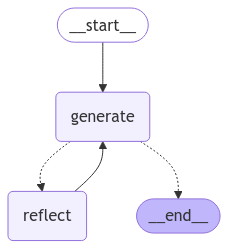

In [25]:
# view the graph
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [89]:
# run self refine iteration
for event in graph.stream(
	[
    	HumanMessage(content=f"Generate minutes of meeting for the given transcript: {transcript}")
	],
	):
    if 'generate' in event:
        print('--- Generating Minutes of Meeting --- \n')
        print(event['generate'])
    else:
        print('--- Validating Minutes of Meeting --- \n')
        print(event['reflect'].content)
    print("\n")

--- Generating Minutes of Meeting --- 

**Meeting Minutes**

**Title:** Marketing and Sales Strategy Meeting for New Product

**Agenda:**

* Review marketing strategy for new product
* Discuss sales projections for upcoming quarter
* Review product development timeline

**Points Discussed:**

• Emily presented a marketing campaign targeting social media platforms and influencer partnerships, aiming to increase brand visibility by at least 20%.
• Jack projected a 15% increase in sales for the next quarter, leveraging the marketing efforts.
• Sarah reported that the product development is on track to meet its deadline, but emphasized the need to finalize the feature list by the end of March.
• Michael reviewed the financials and noted that the budget for marketing and product development is within projections, but cautioned about expenses related to the sales team's travel and training.

**Future Items:**

* Schedule a follow-up meeting in two weeks to review progress

Note: No other bus